In [2]:
from __future__ import annotations
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from numpy.typing import NDArray
from numpy import polymul
import yaml
import seaborn as sns
sns.set_context("paper", font_scale=1.4)

rcfile = yaml.safe_load("""
lines.color: white

patch.edgecolor: white

text.color: white

axes.facecolor: black

axes.edgecolor: white

axes.labelcolor: white

xtick.color: white

ytick.color: white

grid.color: lightgrey

figure.facecolor: black

figure.edgecolor: black

savefig.facecolor: black

savefig.edgecolor: black
""")

matplotlib.rcParams.update(rcfile)
matplotlib.rcParams["figure.facecolor"] = [0,0,0,0]
matplotlib.rcParams["savefig.facecolor"] = [0,0,0,0]

class TF(signal.TransferFunction):
    """Transfer function with multiplication"""

    def __mul__(self, other):
        if type(other) in [int, float]:
            return TF(self.num * other, self.den)
        elif type(other) in [signal.TransferFunction, TF]:
            num = polymul(self.num, other.num)
            den = polymul(self.den, other.den)
            return TF(num, den)
        

class TFD(signal.TransferFunction, signal.dlti):
    """Transfer function with multiplication"""

    def __mul__(self, other):
        if type(other) in [int, float]:
            return TFD(self.num * other, self.den, dt=self.dt)
        elif type(other) in [signal.dlti, TFD]:
            num = polymul(self.num, other.num)
            den = polymul(self.den, other.den)
            assert self.dt == other.dt
            return TFD(num, den, dt=self.dt)


def rc_bode(r, c, w=None):
    """LTI system and frequency response for first-order analog RC filter"""

    # Transfer function: H(s) = 1 / (RCs + 1)
    num = [1.0]
    den = [r * c, 1.0]
    system = signal.TransferFunction(num, den)
    system = TF(system.num, system.den)

    # Frequency response
    w = w if w is not None else np.logspace(1, 6, 500)  # [rad/s]
    w, mag, phase = signal.bode((system.num, system.den), w)

    return system, w, mag, phase


def butter_bode(cutoff_ratio, order, fs, w=None):
    """Digital Butterworth with some cutoff as a fraction of samplerate"""

    # Transfer function
    system = signal.butter(order, Wn=cutoff_ratio * fs, analog=False, fs=fs)
    system = TFD(*system, dt=1.0 / fs)

    # Frequency response
    w = w if w is not None else np.logspace(1, 6, 500)  # [rad/s]
    w, mag, phase = signal.dbode(system, w=w / fs)

    return system, w, mag, phase


def sk(r1, r2, c1, c2):
    # Transfer function for analog Sallen-Key filter
    # https://en.wikipedia.org/wiki/Sallen%E2%80%93Key_topology

    w0 = 1.0 / (r1 * c1 * r2 * c2) ** 0.5  # [rad/s] cutoff frequency
    f0 = w0 / (2.0 * np.pi)  # [Hz]

    # [dimensionless] q factor
    # Butterworth Q = 1/sqrt(2)
    q = (r1 * c1 * r2 * c2) ** 0.5 / (c2 * (r1 + r2))

    alpha = w0 / q / 2  # [rad/s]

    num = [w0**2]
    denom = [1.0, 2 * alpha, w0**2]

    system = signal.TransferFunction(num, denom)
    system = TF(system.num, system.den)

    return system, f0, q


def poly_taps(order: int, delay: float) -> NDArray:
    # Lagrange polynomial fractional delay filter
    # `order` refers to filter order, which is [polynomial order] + 1
    # `delay` is a fraction of a cycle

    taps = np.zeros(order)

    for k in range(order):
        coeff = 1.0
        kv = float(k)
        for m in range(order):
            mv = float(m)
            if m != k:
                coeff *= (delay - mv) / (kv - mv)
        taps[k] = coeff

    return taps


def inv_db(x):
    """Inverse decibel scaling"""
    return 10.0 ** (x / 20.0)


def db(x):
    """Decibel scaling"""
    return 20.0 * np.log10(x)

In [3]:
# RC analog filter params
r = 10.0  # [ohm]
c = 1e-6  # [F]
rc_cutoff = 1 / (2.0 * np.pi * r * c)  # [Hz]

# Reference points
internal_samplerate = 30e3  # [Hz]
reporting_rate = 1e3  # [Hz]

#   [dimensionless] butterworth filter cutoff as a fraction of samplerate
#   with cutoff parked at reporting rate, allowing some aliasing in exchange for
#   reduced phase distortion
butter_cutoff_ratio = reporting_rate / internal_samplerate / 2

#   Analog Sallen-Key filter
r1, r2, c1, c2 = 3.3e3, 3.3e3, 10e-9, 10e-9  # [ohm], [F]

In [4]:
# Timing components
adc_clock_speed = 50e6  # [Hz]
adc_clock_period = 1.0 / adc_clock_speed  # [s]
adc_sample_hold_cycles = 16.5  # [dimensionless]
adc_sample_hold = adc_sample_hold_cycles * adc_clock_period  # [s]
adc_conversion_time = 7.5 * adc_clock_period  # [s] RM0433 25.4.13

# Calculate fractional delay needed for each channel to align with the first sample group
#   Each group starts as soon as the previous one is done
delay_per_group = adc_sample_hold + adc_conversion_time  # [s]

groups = [
    [8, 9, 0],
    [10, 12, 1],
    [11, 13, 2],
    [14, 15, 3],
    [16, 17, 4],
    [18, 5],
    [19, 6],
    [7],
]

delays = np.zeros(20)  # [s] delay of each channel
for i, group in enumerate(groups):
    delays[group] = i * delay_per_group

sample_period = 1.0 / internal_samplerate  # [s]
fractional_delays = delays / sample_period  # [dimensionless]

largest_delay = delays[-1]  # [s]
fractional_delay = largest_delay / sample_period

taps = poly_taps(3, fractional_delay)

In [5]:
# RC filter freq response
rc_sys, rc_w, rc_mag, rc_phase = rc_bode(r, c)

# Analog Sallen-Key filter
sk_sys, sk_f0, sk_q = sk(r1, r2, c1, c2)
print(sk_f0, sk_q)
sk_w, sk_mag, sk_phase = signal.bode((sk_sys.num, sk_sys.den), rc_w)

# Aggregate analog filter
analog_sys = sk_sys * rc_sys
analog_w, analog_mag, analog_phase = signal.bode((analog_sys.num, analog_sys.den), rc_w)

# Sampled analog signal,
# modeling sampling as a zero-order hold (instantaneous sample and constant hold until next sample)
sampled_sys = signal.cont2discrete((analog_sys.num, analog_sys.den), dt=sample_period, method="zoh")
sampled_sys = TFD(sampled_sys[0], sampled_sys[1], dt=sampled_sys[2])

# Fractional delay filter
delay_sys = TFD([1], taps, dt=sample_period)

# Digital Butterworth filter freq response
# Examined only below the internal samplerate
inds = np.where(rc_w < internal_samplerate * 2.0 * np.pi)
# w = rc_w[inds]
butter_sys, butter_w, butter_mag, butter_phase = butter_bode(
    butter_cutoff_ratio, order=2, fs=internal_samplerate, w=rc_w
)

# Digital filtering
digital_filter_sys = butter_sys * delay_sys
digital_w, digital_mag, digital_phase = signal.dbode(digital_filter_sys, w=rc_w / internal_samplerate)

# Aggregate digital signal at internal samplerate
# This method does not properly handle the analog filter's attenuation at high frequencies
# digital_sys = butter_sys * delay_sys * sampled_sys

# Total freq response
# _, total_mag, total_phase, = signal.dbode(digital_sys, w=rc_w / internal_samplerate)
# Rolling the analog system into the digital system doesn't produce a correct result
# because the resulting digital system isn't aware that frequencies above the digital system's
# nyquist frequency can be attenuated by the analog filter.
total_mag = db(inv_db(analog_mag) * inv_db(digital_mag))  # [dB]
total_phase = digital_phase + analog_phase  # [deg]

4822.877063390768 0.5


/home/jlogan/envs/py312/lib/python3.12/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


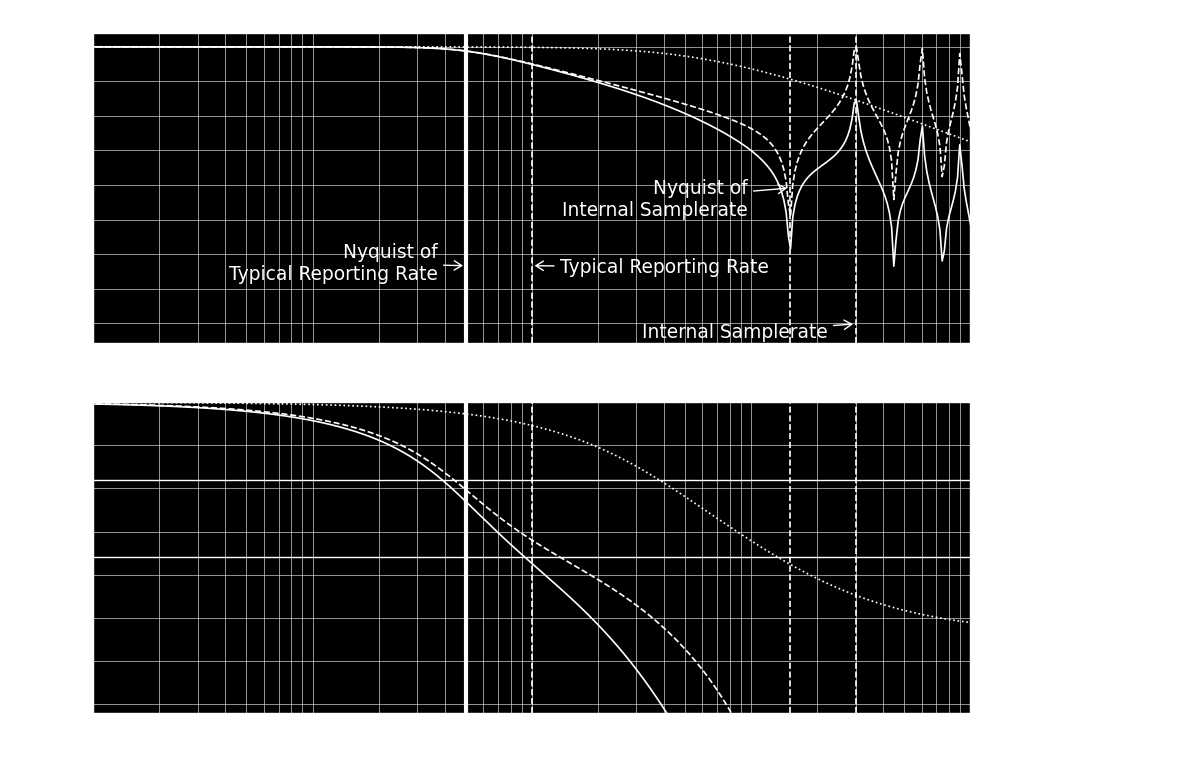

In [6]:
# Magnitude
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
# plt.semilogx(
#     rc_w / (2.0 * np.pi),
#     rc_mag,
#     color="w",
#     linestyle="dotted",
#     label="ADC Input Filter",
# )
# plt.semilogx(
#     rc_w / (2.0 * np.pi),
#     sk_mag,
#     color="w",
#     linestyle="dotted",
#     label="Sallen-Key Filter",
# )
plt.semilogx(
    rc_w / (2.0 * np.pi),
    analog_mag,
    color="w",
    linestyle="dotted",
    label="Analog Filter",
)
plt.semilogx(
    rc_w / (2.0 * np.pi),
    digital_mag,
    color="w",
    linestyle="--",
    label="Digital Filter",
)
plt.semilogx(
    rc_w / (2.0 * np.pi),
    total_mag,
    color="w",
    linestyle="-",
    label="Aggregate Filter",
)
plt.title("Response of Filter Stages 2-5")
plt.ylabel("Magnitude [dB]")
plt.grid(which="both", linewidth=0.5)

ymin, ymax = plt.ylim()
dy = ymax - ymin

plt.axvline(x=internal_samplerate, color="w", linestyle="--")
plt.annotate(
    "Internal Samplerate",
    xy=(internal_samplerate, ymin + dy / 16),
    xytext=(-20, -10),
    textcoords="offset points",
    arrowprops={"linewidth": 1, "facecolor": "k", "arrowstyle": "->,head_width=.25"},
    ha="right",
)

plt.axvline(x=internal_samplerate / 2, color="w", linestyle="--")
plt.annotate(
    "Nyquist of\nInternal Samplerate",
    xy=(internal_samplerate / 2, ymax - dy / 2),
    xytext=(-30, -20),
    textcoords="offset points",
    arrowprops={"linewidth": 1, "facecolor": "k", "arrowstyle": "->,head_width=.25"},
    ha="right",
)

plt.axvline(x=reporting_rate, color="w", linestyle="--")
plt.annotate(
    "Typical Reporting Rate",
    xy=(reporting_rate, ymax - 3 * dy / 4),
    xytext=(20, -5),
    textcoords="offset points",
    arrowprops={"linewidth": 1, "facecolor": "k", "arrowstyle": "->,head_width=.25"},
    ha="left",
)

plt.axvline(x=reporting_rate / 2, color="w", linestyle="-", linewidth=3)
plt.annotate(
    "Nyquist of\nTypical Reporting Rate",
    xy=(reporting_rate / 2, ymax - 3 * dy / 4),
    xytext=(-20, -10),
    textcoords="offset points",
    arrowprops={"linewidth": 1, "facecolor": "k", "arrowstyle": "->,head_width=.25"},
    ha="right",
)

# plt.axvline(x=rc_cutoff, color="w", linestyle="--")
# plt.annotate(
#     "ADC Input\nFilter Cutoff",
#     xy=(rc_cutoff, ymax - 3 * dy / 4),
#     xytext=(-20, -10),
#     textcoords="offset points",
#     arrowprops={"linewidth": 1, "facecolor": "k", "arrowstyle": "->,head_width=.25"},
#     ha="right",
# )
plt.xlim(left=np.min(rc_w), right=1e5)

plt.legend(bbox_to_anchor=[1, 1, 0, 0], loc="upper left", borderaxespad=0.01, framealpha=0)

# Phase
plt.subplot(2, 1, 2)
plt.semilogx(
    rc_w / (2.0 * np.pi),
    analog_phase,
    color="w",
    linestyle="dotted",
    label="Analog Filter",
)
plt.semilogx(
    rc_w[inds] / (2.0 * np.pi),
    digital_phase[inds],
    color="w",
    linestyle="--",
    label="Digital Filter",
)
plt.semilogx(
    rc_w[inds] / (2.0 * np.pi),
    total_phase[inds],
    color="w",
    linestyle="-",
    label="Aggregate Filter",
)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [deg]")
plt.grid(which="both", linewidth=0.5)

plt.axvline(x=internal_samplerate, color="w", linestyle="--")
plt.axvline(x=internal_samplerate / 2, color="w", linestyle="--")
plt.axvline(x=reporting_rate, color="w", linestyle="--")
plt.axvline(x=reporting_rate / 2, color="w", linestyle="-", linewidth=3)
# plt.axvline(x=rc_cutoff, color="w", linestyle="--")
plt.axhline(y=-180, color="w", linewidth=1)
plt.axhline(y=-90, color="w", linewidth=1)

plt.xlim(left=np.min(rc_w), right=1e5)
plt.ylim(-360, 0)

# plt.legend(bbox_to_anchor=[1, 1, 0, 0], loc="upper left")

plt.tight_layout()

plt.savefig("./sk_3kHz.svg", transparent=True)
plt.show()
